In [44]:
import torch
from mirtorch.prox import prox
from mirtorch.linear import *
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

In [163]:
#initial implementation
class FISTA():
    def __init__(self, max_iter, step, fval, grad, prox, momentum = 1, restart = False):
        self.max_iter = max_iter
        self.step = step
        self.fval = fval
        self.grad = grad
        self.prox = prox
        self.momentum = momentum
        self.restart = restart
    '''
    Experimenting different implementation
    '''
    def _update(self):
        #looks like one possible implementation from jeff lecture slides
        step_prev = self.step
        self.step = (1 + np.sqrt(1 + 4*step_prev*step_prev))/2
        self.momentum = (step_prev-1)/self.step
        #print(f'\t Now step={self.step}, momentum={self.momentum}')

    def run_alg(self, x0):
        x_curr = x0
        z_curr = x0 
        for i in range(self.max_iter):
            #print(f'Before iter {i+1}, \n \t z = {z_curr}, x = {x_curr}')
            self._update()
            x_prev = x_curr
            z_prev = z_curr
            #compute new z_k and x_k
            #print(x_curr.shape, z_curr.shape)
            #print(self.grad(x_prev))
            #print(x_prev - self.grad(x_prev))
            z_curr = self.prox(x_prev - self.grad(x_prev))
            #print(f'\tIn iter {i+1}, grad calculated to be {self.grad(x_prev)}')
            x_curr = z_curr + self.momentum * (z_curr - z_prev)
            #x_curr = (1-self.momentum)*z_curr + self.momentum*z_prev
            #print(f'In iter {i}, x_curr calculated to be {x_curr}')
            #update momentum value for next iteration
            #self._update()
        return x_curr

In [93]:
class A(LinearMap):
    def __init__(self):
        super().__init__([2], [2])
        self.mat = torch.Tensor([[2,0],[0,1]])
    def _apply(self, x):
        return torch.matmul(self.mat,x)
    def _apply_adjoint(self,x):
        return self._apply(x)
    
class grad(LinearMap):
    def __init__(self):
        super().__init__([2],[2])
        self._A = A()
    def _apply(self, x):
        y = self._A(x)
        #print(y)
        y -= torch.Tensor([2,1])
        #print(y)
        y = self._A(y)
        return 2/17 * y #17 is needed to account for L lipshitz constant
    

In [94]:
f = FISTA(300, 1, None, grad(), prox.L1Regularizer(.001))

In [97]:
f.run_alg(torch.Tensor([5,5]))

tensor([0.9979, 0.9915])

In [119]:
#Binary classification on MNIST digits using FISTA (specifically 3 and 6)
#get dataset
#uncomment to retech data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.float64)
X_orig, y_orig = X, y
print(len(X))
print(len(X[y==3]))
print(len(X[y==5]))
print(len(X[(y==3) | (y==5)]))

def show_digit(X, y):
    digit_image = X.reshape(28,28)
    print(f'Expected digit {y+4}')
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

70000
7141
6313
13454


(13454, 784) (13454,)
Expected digit 5.0


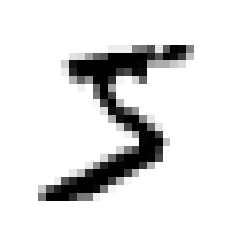

In [120]:
#reduce data to be binary classification for simplicity
X, y = X[(y==3) | (y==5)], y[(y==3) | (y==5)]
y = y - 4
print(X.shape, y.shape)
show_digit(X[0], y[0])
#create train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=3454)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)
#let digit 3 = -1
#let digit 6 = 1



In [205]:
#define grad callable
X_train = X_train.type(torch.float32)
X_test = X_test.type(torch.float32)
y_train = y_train.type(torch.float32)
y_test = y_test.type(torch.float32)
def hubergrad(x, dh = .1):
    if x >= 1:
        return 0
    elif x < 1 and x > 1 - dh:
        return (x-1)/dh
    else:
        return -1
class A(LinearMap):
    def __init__(self):
        self._A = X_train.clone()
        for i in range(self._A.shape[0]):
            self._A[i] *= y_train[i]
        
        super().__init__([28*28], [10000])
    def _apply(self, x):
        return torch.matmul(self._A, x)
    def _apply_adjoint(self, x):
        return torch.matmul(self._A.T, x)
        
class grad:
    def __init__(self, dh=.1):
        self.a = A()
        self.L = 1/dh * torch.norm(self.a._A.T)
        
    def __call__(self, x):
        x = self.a(x)
        x = x.apply_(hubergrad)
        x = self.a.adjoint(x)
        x = 1/self.L * x
        #print(x)
        return x
def eval(x):
    res = torch.matmul(X_test, x)
    res = torch.sign(res)
    res *= y_test
    print(f'Correct {res[res > 0].shape}')
    print(f'Incorrect {res[res < 0].shape}')
        

In [221]:
f = FISTA(50, 1, None, grad(), prox.L1Regularizer(.001))

In [222]:
res = f.run_alg(torch.zeros(28*28, dtype=torch.float32))

res

In [223]:
eval(res)

Correct torch.Size([3244])
Incorrect torch.Size([210])
